In [1]:
import os
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold,GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import seaborn as sns
from tools import *
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/celina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/celina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Analyse de sentiments

Nous disposons d'un ensemble de revues contenant 1000 avis positifs et 1000 avis negatifs.

l'objectif de la tâche est de construire un modèle qui prédit si le commentaire d'un internaute est positif ou negatif. 

Les classes étant equilibrés, nous utilisons le taux de bonnes classifications comme indicateur de perfomances.

Nous considérerons dans un premier temps trois classifieurs : SVM avec un kernel linéaire, Naive Bayes et Regression Logistique. Nous fixons le nombre d'itérations à 5000 et nous optimisons l'intensité de la regularisation (paramètre C) pour le classifieur SVM et la regression logistique avec une validation croisée avec 5 folds. En effet, la regularisation est importante car dans certains cas, on aura plus de features que de données ce qui entraine un eventuel sur-apprentissage (= une variabilité faible).



In [3]:
files = 'movies1000/'

#### Version 0 : CountVectorizer, Unigrams et sans préprocessing

In [7]:
stemmization = False
stopwords = False 
lower = False
vector = 'count'
ngrams = (1,1)
X_train,labels,vectorizer = process_data(files,vector,stemmization, 
                                stopwords,ngrams,lower=False,remove_num=False)

In [8]:
Cvalues, LR, SVM = regularization_tuning(X_train,labels,max_iter=8000)

C 		 Logistic Regression 		 Linear SVM
0.01 			 0.831 			 0.83
0.02 			 0.836 			 0.825
0.05 			 0.835 			 0.82
0.08 			 0.836 			 0.819
0.1 			 0.837 			 0.818
0.25 			 0.837 			 0.816
0.35 			 0.836 			 0.817
0.5 			 0.836 			 0.818
1 			 0.832 			 0.817


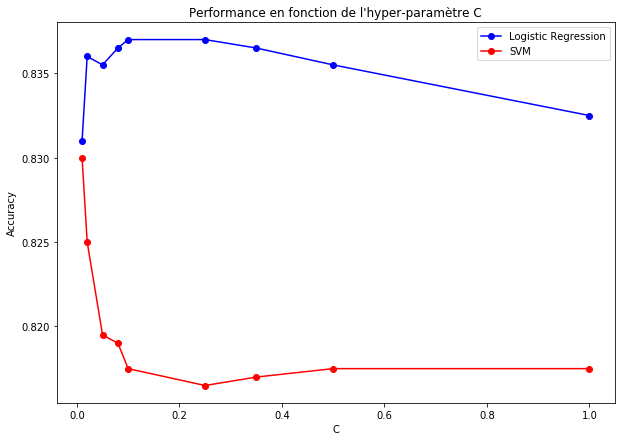

In [20]:
plt.figure(figsize=(10,7))
plt.plot(Cvalues, LR, '-bo', label= 'Logistic Regression')
plt.plot(Cvalues, SVM, '-ro',label= 'SVM')
plt.title("Performance en fonction de l'hyper-paramètre C")
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.savefig('Version1.jpg')

In [25]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfSVM.fit(X_train,labels)
clfLR = LogisticRegression(C=0.25,max_iter=5000)
clfLR.fit(X_train,labels)
clfNB = MultinomialNB()
clfNB.fit(X_train,labels)
positiveSVM, negativeSVM, positiveLR, negativeLR = print_words(clfSVM,clfLR,clfNB,vectorizer)

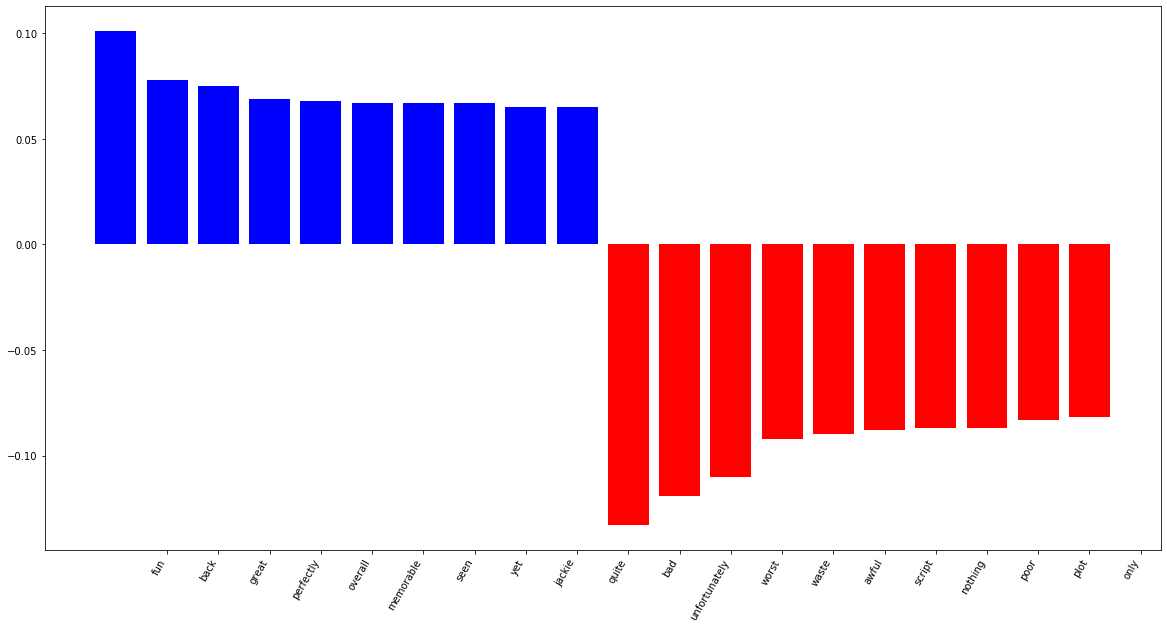

In [48]:
coefSVM = np.concatenate((positiveSVM, negativeSVM))
coeffsSVM = coefSVM[:,1].astype(float)
wordsSVM = coefSVM[:,0]
plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "blue" for c in coeffsSVM]
plt.bar(np.arange(2 * 10), coeffsSVM, color=colors)
feature_names = np.array(wordsSVM)
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names, rotation=60, ha="right")
plt.savefig('Version0_wordsSVM.jpg')
plt.show()


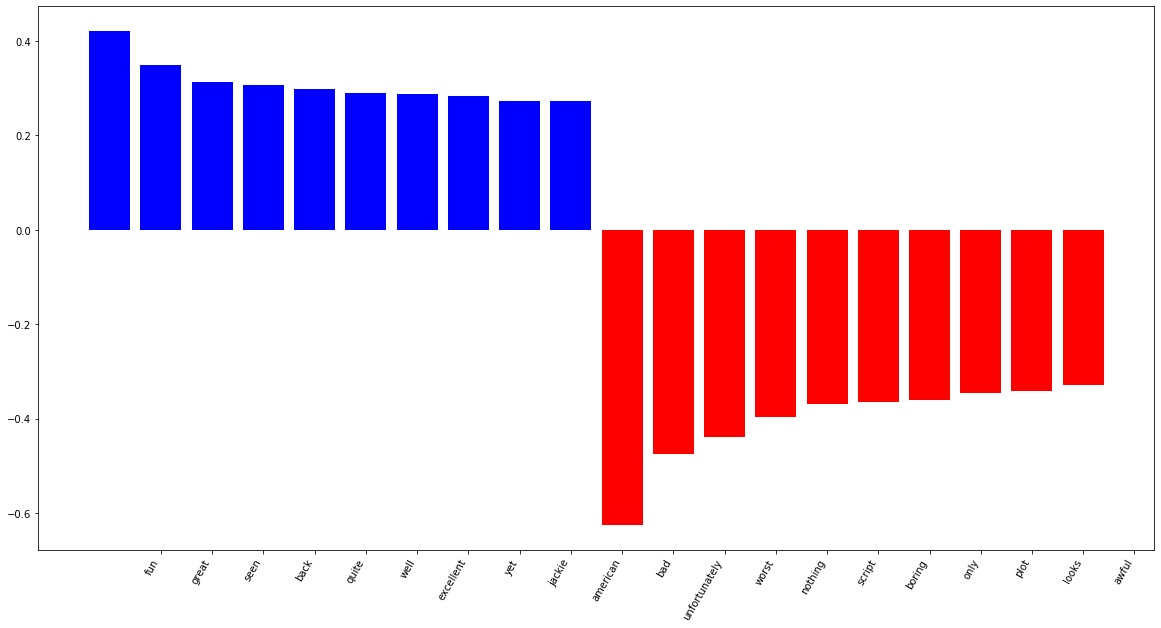

In [47]:
coefLR = np.concatenate((positiveLR, negativeLR))
coeffsLR = coefLR[:,1].astype(float)
wordsLR = coefLR[:,0]
plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "blue" for c in coeffsLR]
plt.bar(np.arange(2 * 10), coeffsLR, color=colors)
feature_names = np.array(wordsLR)
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names, rotation=60, ha="right")
plt.savefig('Version0_wordsLR.jpg')
plt.show()

In [30]:
clfLR = LogisticRegression(C=0.05,max_iter=5000)
clfLR.fit(X_train,labels)
feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), clfLR.coef_[0]
    )
}
print("----- 10 most positive words ------\n")
positive = sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]
for best_positive in positive :
    print (best_positive)
print("----- 10 most negative words ------\n")
negative = sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]
for best_negative in negative:
    print (best_negative)
pos = ' '.join(list(np.asarray(positive)[:,0]))
neg = ' '.join(list(np.asarray(negative)[:,0]))

----- 10 most positive words ------

('fun', 0.2764322911628378)
('great', 0.24655260549368438)
('seen', 0.22247010846991452)
('quite', 0.20888062748303582)
('well', 0.20742484809063555)
('back', 0.19855052904154533)
('yet', 0.1878797571298714)
('excellent', 0.18550326779585002)
('jackie', 0.18502350205062662)
('american', 0.1817602271553672)
----- 10 most negative words ------

('bad', -0.4528996600819968)
('unfortunately', -0.3106576977895418)
('worst', -0.29518616357112015)
('nothing', -0.2728203469916015)
('only', -0.2614188699035728)
('script', -0.25664247403177204)
('boring', -0.2500068303998244)
('plot', -0.24857930415481125)
('looks', -0.23524619557369889)
('supposed', -0.2162664658698285)


Il est intéressant de considérer les majuscules dans le cadre d’une revue, on a plus tendance à écrire en majuscule des mots souvent discriminants. Dans la suite, nous testerons l'influence de la stemmization, des stopwords et de la vectorisation.

#### Version 1 : CountVectorizer, Unigram,  StopWords : YES, Stemming : YES

In [49]:
stemmization = True
stopwords = True
vector = 'count'
ngrams = (1,1)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams)

In [50]:
Cvalues, LR, SVM = regularization_tuning(X_train,labels,max_iter=8000)

C 		 Logistic Regression 		 Linear SVM
0.01 			 0.848 			 0.834
0.02 			 0.846 			 0.832
0.05 			 0.845 			 0.83
0.08 			 0.844 			 0.83
0.1 			 0.843 			 0.828
0.25 			 0.843 			 0.826
0.35 			 0.843 			 0.825
0.5 			 0.844 			 0.826
1 			 0.842 			 0.825


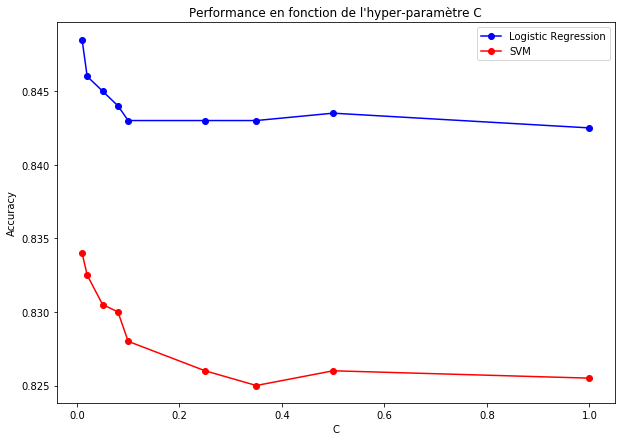

In [51]:
plt.figure(figsize=(10,7))
plt.plot(Cvalues, LR, '-bo', label= 'Logistic Regression')
plt.plot(Cvalues, SVM, '-ro',label= 'SVM')
plt.title("Performance en fonction de l'hyper-paramètre C")
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.savefig('Version2.jpg')

Dans la suite on fixera C = 0.01 pour SVM et C = 0.05 pour la regression logistique.

In [55]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.834
Naive Bayes : 0.799
Logistic Regression : 0.845


In [56]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
positiveSVM, negativeSVM, positiveLR, negativeLR = print_words(clfSVM, clfLR,clfNB,vectorizer)

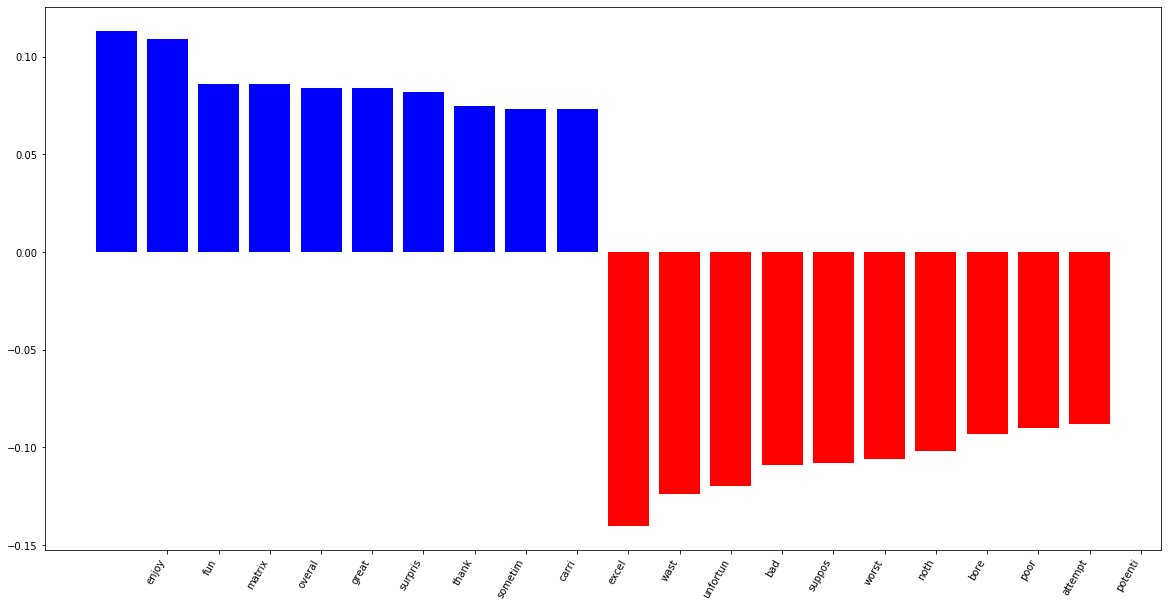

In [57]:
coefSVM = np.concatenate((positiveSVM, negativeSVM))
coeffsSVM = coefSVM[:,1].astype(float)
wordsSVM = coefSVM[:,0]
plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "blue" for c in coeffsSVM]
plt.bar(np.arange(2 * 10), coeffsSVM, color=colors)
feature_names = np.array(wordsSVM)
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names, rotation=60, ha="right")
plt.savefig('Version1_wordsSVM.jpg')
plt.show()

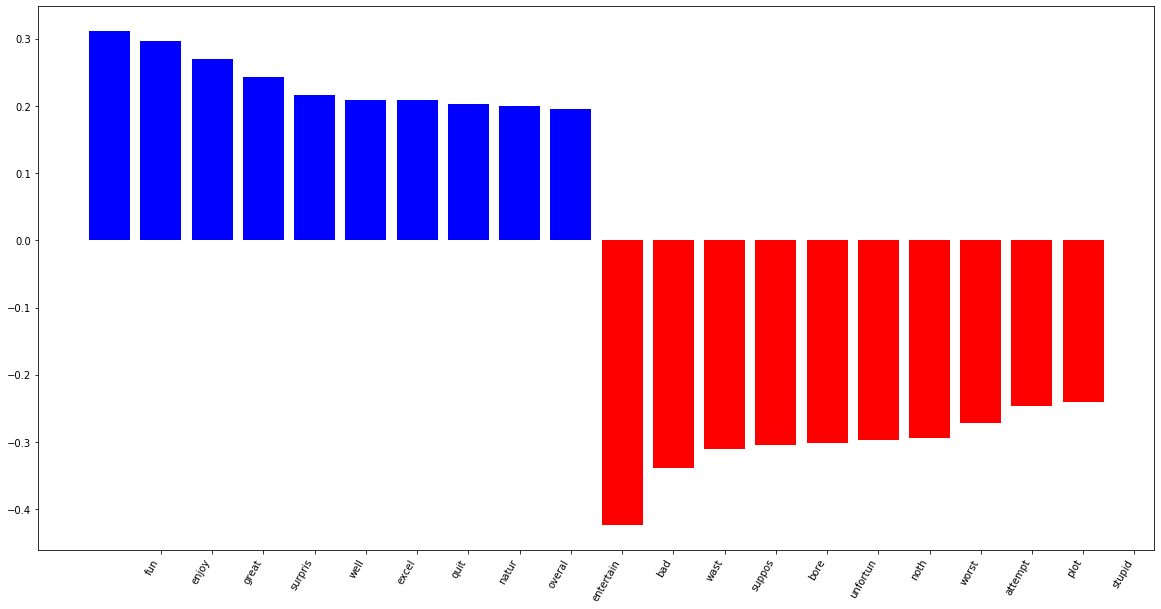

In [58]:
coefLR = np.concatenate((positiveLR, negativeLR))
coeffsLR = coefLR[:,1].astype(float)
wordsLR = coefLR[:,0]
plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "blue" for c in coeffsLR]
plt.bar(np.arange(2 * 10), coeffsLR, color=colors)
feature_names = np.array(wordsLR)
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names, rotation=60, ha="right")
plt.savefig('Version1_wordsLR.jpg')
plt.show()

#### Version 2 : CountVectorizer, Unigram,  StopWords = YES, Stemming = NO

In [20]:
stemmization = False
stopwords = True
vector = 'count'
ngrams = (1,1)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams)

In [21]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.844
Naive Bayes : 0.82
Logistic Regression : 0.8475


In [22]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
print_words(clfSVM, clfLR,clfNB,vectorizer)

------------------- 10 most positive words ----------------------

- Logistic Regression :
 ['fun' 'great' 'well' 'quite' 'overall' 'memorable' 'seen' 'others'
 'different' 'excellent']

- SVM:
 ['fun' 'great' 'overall' 'well' 'memorable' 'terrific' 'others' 'matrix'
 'pace' 'perfectly']

- Naive Bayes:
 ['film' 'one' 'movie' 'like' 'good' 'time' 'story' 'films' 'also' 'even']



-------------------- 10 most negative words ---------------------

- Logistic Regression :
 ['bad' 'worst' 'unfortunately' 'supposed' 'nothing' 'looks' 'boring'
 'script' 'plot' 'reason']

- SVM:
 ['bad' 'unfortunately' 'worst' 'supposed' 'waste' 'reason' 'poor' 'looks'
 'awful' 'nothing']

- Naive Bayes:
 ['00s' '05425' '1000' '101' '10b' '10s' '10th' '11' '115' '11th']


#### Version 3 : CountVectorizer, Bigrams,  StopWords = YES, Stemming = NO

In [69]:
stemmization = False
stopwords = True
vector = 'count'
ngrams = (2,2)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams)

In [70]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.7855
Naive Bayes : 0.7555
Logistic Regression : 0.7805


In [71]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
positiveSVM, negativeSVM, positiveLR, negativeLR = print_words(clfSVM, clfLR,clfNB,vectorizer)

In [76]:
negativeLR[:,0]

array(['bad movie', 'waste time', 'one worst', 'bad guy', 'looks like',
       'much better', 'even worse', 'batman robin', 'everyone else',
       'five minutes'], dtype='<U13')

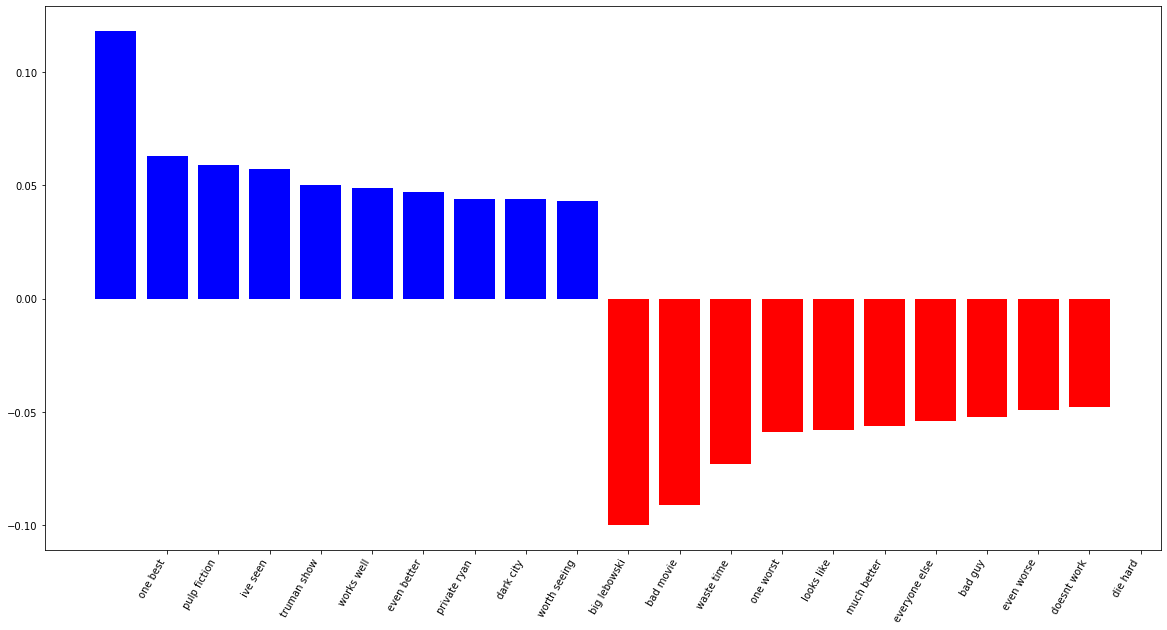

In [67]:
coefSVM = np.concatenate((positiveSVM, negativeSVM))
coeffsSVM = coefSVM[:,1].astype(float)
wordsSVM = coefSVM[:,0]
plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "blue" for c in coeffsSVM]
plt.bar(np.arange(2 * 10), coeffsSVM, color=colors)
feature_names = np.array(wordsSVM)
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names, rotation=60, ha="right")
plt.savefig('Version2_wordsSVM.jpg')
plt.show()

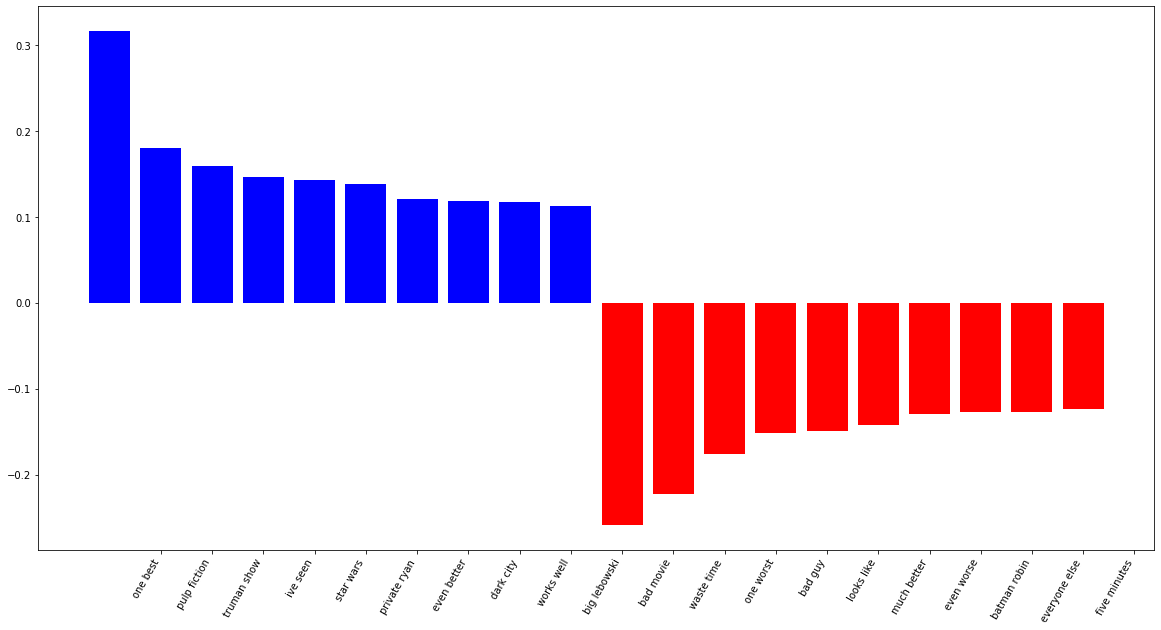

In [68]:
coefLR = np.concatenate((positiveLR, negativeLR))
coeffsLR = coefLR[:,1].astype(float)
wordsLR = coefLR[:,0]
plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "blue" for c in coeffsLR]
plt.bar(np.arange(2 * 10), coeffsLR, color=colors)
feature_names = np.array(wordsLR)
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names, rotation=60, ha="right")
plt.savefig('Version2_wordsLR.jpg')
plt.show()

#### Version 4 : Binaire, Unigrams,  StopWords = NO, Stemming = NO

In [27]:
stemmization = False
stopwords = False
vector = 'binary'
ngrams = (1,1)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams)

In [28]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.8585
Naive Bayes : 0.8255
Logistic Regression : 0.8645


In [29]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
print_words(clfSVM, clfLR,clfNB,vectorizer)

------------------- 10 most positive words ----------------------

- Logistic Regression :
 ['hilarious' 'memorable' 'others' 'fun' 'performances' 'very' 'terrific'
 'great' 'excellent' 'sometimes']

- SVM:
 ['memorable' 'fun' 'hilarious' 'terrific' 'others' 'sometimes' 'excellent'
 'pace' 'performances' 'wonderfully']

- Naive Bayes:
 ['of' 'the' 'and' 'to' 'in' 'is' 'that' 'with' 'it' 'as']



-------------------- 10 most negative words ---------------------

- Logistic Regression :
 ['bad' 'worst' 'nothing' 'script' 'plot' 'unfortunately' 'boring'
 'supposed' 'awful' 'only']

- SVM:
 ['bad' 'worst' 'awful' 'nothing' 'plot' 'waste' 'poor' 'unfortunately'
 'boring' 'script']

- Naive Bayes:
 ['00s' '05425' '1000' '101' '10b' '10s' '10th' '11' '115' '11th']


#### Version 5 : Binaire, Bigrams,  StopWords = NO, Stemming = NO

In [4]:
stemmization = False
stopwords = True
vector = 'binary'
ngrams = (1,2)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams,max_feat=60000)

In [5]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.865
Naive Bayes : 0.837
Logistic Regression : 0.871


In [83]:
def create_wordcloud(clfSVM, clfLR,clfNB, X_train, labels,vectorizer):
    positiveSVM, negativeSVM, positiveLR, negativeLR = print_words(clfSVM, clfLR,clfNB,
                                                                   vectorizer)
    tab =  [positiveSVM, negativeSVM,positiveLR,negativeLR]
    tab = [' '.join(list(t[:,0])) for t in tab]
    clouds = []
    for i in range(len(tab)):
        worldcloud = WordCloud(width = 800, height = 800, 
                               background_color ='white', min_font_size = 5).generate(tab[i])
        clouds.append(worldcloud)
    return clouds

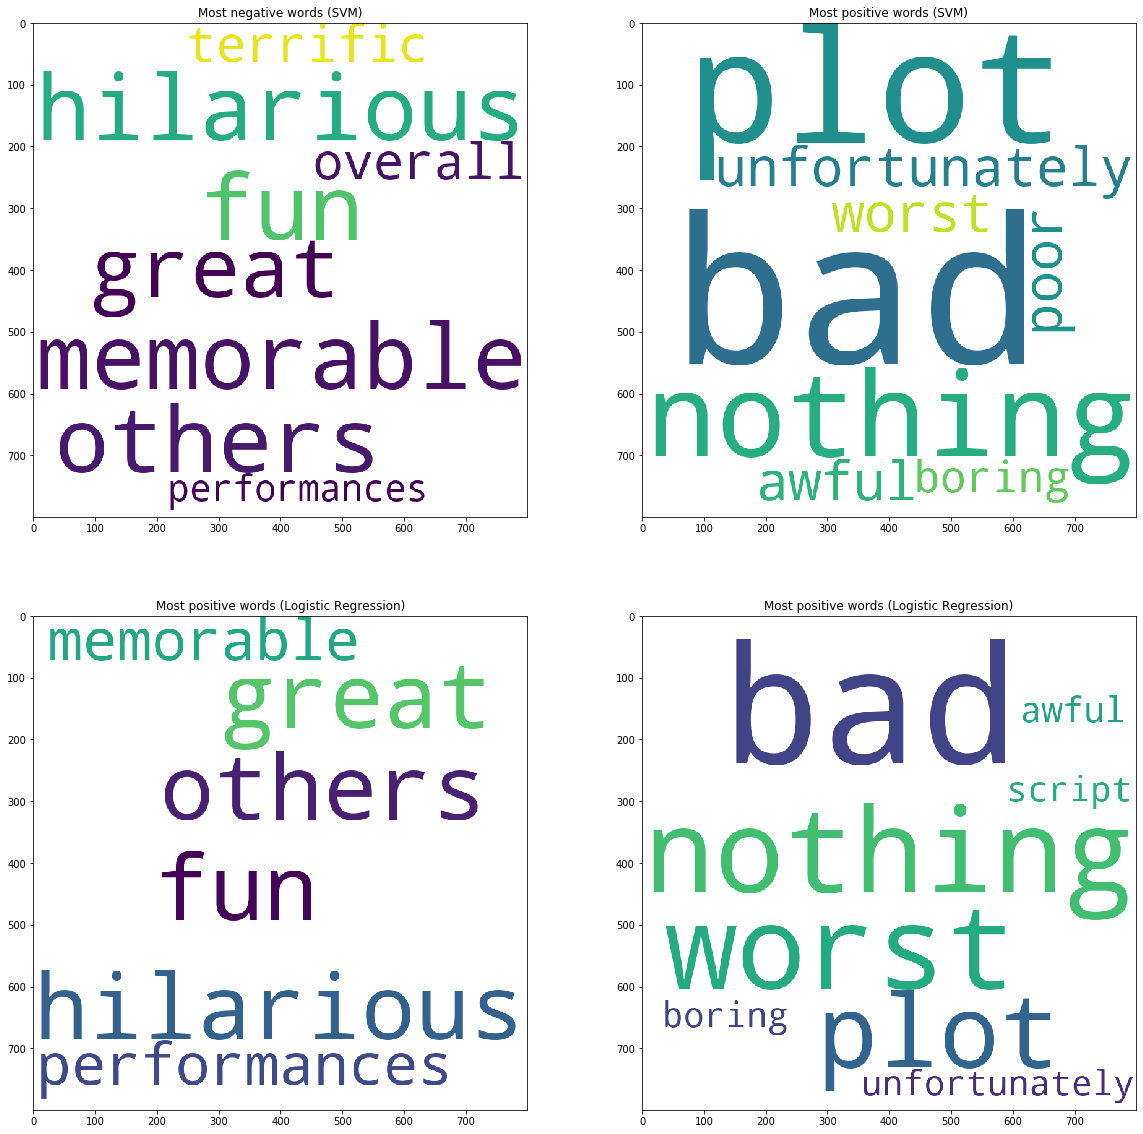

In [85]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
clouds = create_wordcloud(clfSVM, clfLR, clfNB,X_train, labels,vectorizer)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Most negative words (SVM)')
ax1.imshow(clouds[0])
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Most positive words (SVM)')
ax2.imshow(clouds[1])
ax3 = fig.add_subplot(2,2,3)
ax3.set_title('Most positive words (Logistic Regression)')
ax3.imshow(clouds[2])
ax4 = fig.add_subplot(2,2,4)
ax4.set_title('Most positive words (Logistic Regression)')
ax4.imshow(clouds[3])
plt.savefig("Version4_cloud.jpg")




À chaque fois nous avons conservé tous les mots, faisons varier cet hyperparamètre pour observer son influence sur un modèle SVM:

### NE PAS EXECUTER LA CELLULE SUIVANTE : mets trop de temps à s'executer

TODO : faire un split des données

In [8]:
from tqdm import tqdm
stemmization = False
stopwords = False
vector = 'binary'
ngrams = (1,2)
max_features_values = np.arange(100,100000,1000)
perfs = []
for i in tqdm(range(len(max_features_values))):
    X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,
                                             ngrams,max_feat=max_features_values[i])
    clfSVM = LinearSVC(C=0.01,max_iter=5000)
    clfSVM.fit(X_train,labels)
    perfs.append(np.mean(cross_val_score(clfSVM, X_train, labels, cv=5)))



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:05<08:54,  5.39s/it]

  2%|▏         | 2/100 [00:10<08:53,  5.45s/it]

  3%|▎         | 3/100 [00:16<08:54,  5.51s/it]

  4%|▍         | 4/100 [00:22<09:06,  5.70s/it]

  5%|▌         | 5/100 [00:28<09:09,  5.78s/it]

  6%|▌         | 6/100 [00:34<09:09,  5.84s/it]

  7%|▋         | 7/100 [00:40<09:11,  5.93s/it]

  8%|▊         | 8/100 [00:47<09:17,  6.06s/it]

  9%|▉         | 9/100 [00:53<09:21,  6.17s/it]

 10%|█         | 10/100 [01:00<09:20,  6.23s/it]

 11%|█         | 11/100 [01:06<09:19,  6.29s/it]

 12%|█▏        | 12/100 [01:13<09:28,  6.46s/it]

 13%|█▎        | 13/100 [01:20<09:39,  6.66s/it]

 14%|█▍        | 14/100 [01:27<09:30,  6.64s/it]

 15%|█▌        | 15/100 [01:33<09:18,  6.57s/it]

 16%|█▌        | 16/100 [01:39<09:08,  6.54s/it]

 17%|█▋        | 17/100 [01:46<09:02,  6.54s/it]

 18%|█▊        | 18/100 [01:52<08:55,  6.53s/it]

 19%|█▉        | 19/100 [01:59<08:58,  6.65s/it]

 20%|██        |

Accuracy max : 0.8789999999999999 pour un nombre de mots conservés : 74100


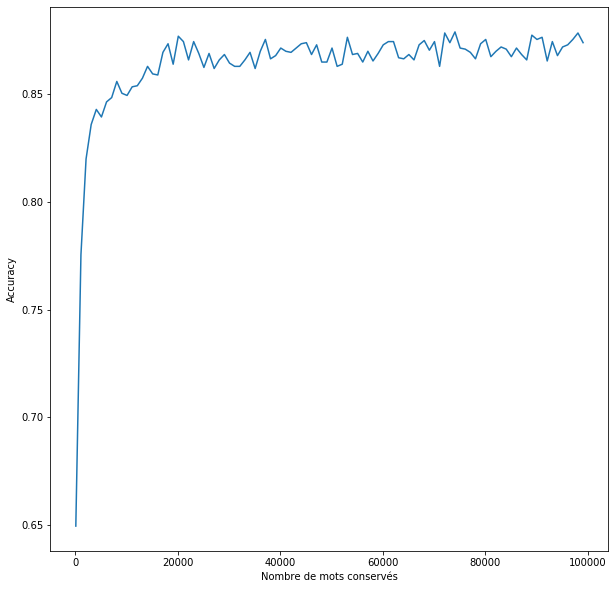

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Nombre de mots conservés')
ax.plot(max_features_values,perfs)
print("Accuracy max : {} pour un nombre de mots conservés : {}".format(np.max(perfs), max_features_values[np.argmax(perfs)]))
plt.savefig("nb_words.jpg")

#### Version 5 : Binaire,  Bigrams,  StopWords = YES, Stemming = NO

In [87]:
stemmization = False
stopwords = True
vector = 'binary'
ngrams = (1,2)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams,max_feat = 60000)

In [93]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.865
Naive Bayes : 0.8415
Logistic Regression : 0.8735


In [95]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
positiveSVM, negativeSVM, positiveLR, negativeLR = print_words(clfSVM, clfLR,clfNB,vectorizer)

In [99]:
positiveSVM

array([['memorable', '0.095'],
       ['hilarious', '0.094'],
       ['others', '0.09'],
       ['fun', '0.086'],
       ['terrific', '0.084'],
       ['sometimes', '0.078'],
       ['overall', '0.076'],
       ['excellent', '0.075'],
       ['great', '0.075'],
       ['performances', '0.074']], dtype='<U12')

In [100]:
positiveLR

array([['hilarious', '0.258'],
       ['memorable', '0.232'],
       ['others', '0.232'],
       ['fun', '0.223'],
       ['great', '0.22'],
       ['performances', '0.216'],
       ['terrific', '0.206'],
       ['different', '0.204'],
       ['excellent', '0.204'],
       ['sometimes', '0.204']], dtype='<U12')

In [101]:
negativeLR

array([['bad', '-0.425'],
       ['worst', '-0.348'],
       ['nothing', '-0.316'],
       ['boring', '-0.311'],
       ['plot', '-0.302'],
       ['supposed', '-0.298'],
       ['script', '-0.297'],
       ['unfortunately', '-0.293'],
       ['awful', '-0.263'],
       ['mess', '-0.251']], dtype='<U13')

In [102]:
negativeSVM

array([['bad', '-0.13'],
       ['worst', '-0.124'],
       ['nothing', '-0.11'],
       ['plot', '-0.108'],
       ['awful', '-0.106'],
       ['boring', '-0.106'],
       ['supposed', '-0.106'],
       ['unfortunately', '-0.102'],
       ['poor', '-0.1'],
       ['script', '-0.099']], dtype='<U13')

clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
clouds = create_wordcloud(clfSVM, clfLR, clfNB,X_train, labels,vectorizer)
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Most negative words (SVM)')
ax1.imshow(clouds[0])
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Most positive words (SVM)')
ax2.imshow(clouds[1])
ax3 = fig.add_subplot(2,2,3)
ax3.set_title('Most positive words (Logistic Regression)')
ax3.imshow(clouds[2])
ax4 = fig.add_subplot(2,2,4)
ax4.set_title('Most positive words (Logistic Regression)')
ax4.imshow(clouds[3])
plt.savefig("Version5_cloud.jpg")

#### Version 6 : TFIDF, Bigrams,  StopWords = NO, Stemming = NO

In [113]:
stemmization = False
stopwords = False
vector = 'tfidf'
ngrams = (1,2)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams,max_feat = 60000)

In [114]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.7825
Naive Bayes : 0.7715
Logistic Regression : 0.7755


In [116]:
clfSVM.fit(X_train,labels)
clfLR.fit(X_train,labels)
clfNB.fit(X_train,labels)
print_words(clfSVM, clfLR, clfNB, vectorizer,verbose=True)

------------------- 10 most positive words ----------------------

- Logistic Regression :
 ['life' 'great' 'he is' 'also' 'world' 'both' 'as the' 'perfect'
 'the best' 'family']

- SVM:
 ['life' 'great' 'he is' 'also' 'world' 'both' 'perfect' 'the best'
 'as the' 'very']

- Naive Bayes:
 ['his' 'film' 'he' 'are' 'by' 'its' 'an' 'in the' 'who' 'one']



-------------------- 10 most negative words ---------------------

- Logistic Regression :
 ['bad' 'worst' 'boring' 'plot' 'supposed' 'supposed to' 'nothing' 'script'
 'why' 'have']

- SVM:
 ['bad' 'worst' 'boring' 'plot' 'supposed' 'nothing' 'script' 'supposed to'
 'why' 'unfortunately']

- Naive Bayes:
 ['worst' 'boring' 'supposed to' 'supposed' 'worse' 'none' 'attempt'
 'whats' 'if the' 'material']


(array([['life', '0.214'],
        ['great', '0.194'],
        ['he is', '0.181'],
        ['also', '0.166'],
        ['world', '0.159'],
        ['both', '0.156'],
        ['perfect', '0.154'],
        ['the best', '0.152'],
        ['as the', '0.15'],
        ['very', '0.149']], dtype='<U8'),
 array([['bad', '-0.362'],
        ['worst', '-0.251'],
        ['boring', '-0.206'],
        ['plot', '-0.193'],
        ['supposed', '-0.174'],
        ['nothing', '-0.166'],
        ['script', '-0.166'],
        ['supposed to', '-0.164'],
        ['why', '-0.155'],
        ['unfortunately', '-0.153']], dtype='<U13'),
 array([['life', '0.294'],
        ['great', '0.255'],
        ['he is', '0.247'],
        ['also', '0.221'],
        ['world', '0.215'],
        ['both', '0.209'],
        ['as the', '0.205'],
        ['perfect', '0.204'],
        ['the best', '0.202'],
        ['family', '0.199']], dtype='<U8'),
 array([['bad', '-0.483'],
        ['worst', '-0.332'],
        ['boring', '-0.271'

#### Version 7 : TFIDF, Bigrams,  StopWords = YES, Stemming = NO

In [3]:
stemmization = False
stopwords = True
vector = 'tfidf'
ngrams = (1,2)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams,max_feat = 60000)

In [4]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.7805
Naive Bayes : 0.773
Logistic Regression : 0.7755


#### Version 8 : TFIDF, Bigrams,  StopWords = YES, Stemming = YES

In [5]:
stemmization = True
stopwords = True
vector = 'tfidf'
ngrams = (1,2)
X_train,labels,vectorizer = process_data(files,vector,stemmization,stopwords,ngrams,max_feat = 60000)

In [6]:
clfSVM = LinearSVC(C=0.01,max_iter=5000)
clfNB = MultinomialNB()
scoresNB = cross_val_score(clfNB, X_train, labels, cv=5)
scoresSVM = cross_val_score(clfSVM, X_train, labels, cv=5)
clfLR = LogisticRegression(C=0.05,max_iter=5000)
scoresLR = cross_val_score(clfLR, X_train, labels, cv=5)
print("SVM : {}".format(round(np.mean(scoresSVM),4)))
print("Naive Bayes : {}".format(round(np.mean(scoresNB),4)))
print("Logistic Regression : {}".format(round(np.mean(scoresLR),4)))

SVM : 0.8
Naive Bayes : 0.7915
Logistic Regression : 0.794


In [11]:
test_file = '/home/celina/S2/RITAL/NLP/data/testSentiment.txt'
donnees_test = load_data_test(test_file,stemmization, stopw=stopwords,numbers=True)
donnees_test = vectorizer.transform(donnees_test)


In [12]:
clfSVM.fit(X_train,labels)
y_pred = clfSVM.predict(donnees_test)
y_pred = convert_pred(y_pred)
write_pred(y_pred,'SVM_BINARY_BIGRAMS_SW-NO_STEM-NO')

In [13]:
clfLR.fit(X_train,labels)
y_pred = clfLR.predict(donnees_test)
y_pred = convert_pred(y_pred)
write_pred(y_pred,'LR_BINARY_BIGRAMS_SW-NO_STEM-NO')

#### Tableau récapitulatif :



##### Validation croisée avec 5 folds

| Codage | Stemming   | Stop words   | SVM   | Logistic Regression   | Naive Bayes   |
|------|------|------|------|------|------|
|   TF (Unigrams) | NO| NO| 83 %| 84 %| 83 %|
|   TF (Unigrams) | NO| YES| 84%| 84 %| 82 %|
|   TF (Bigrams)  | NO| NO| 85.4 %| 85.15 %| 83.65 %|
|   Presence (Unigrams)  | NO| NO| 85.85 %| 86.45 %| 82.55 %|
|   Presence (Bigrams)  | NO| NO| 87.76 %| 87.65 %| 84.65 %|
|   Presence (Bigrams)  | NO| YES| 86.75 %| 87.3 %| 83.65 %|
|   TF-IDF (Bigrams)  | NO| NO| 78.25 %| 77.55 %| 77.15 %|
|   TF-IDF (Bigrams)  | NO| YES| 78.05 %| 77.55 %| 77.3 %|
|   TF-IDF (Bigrams)  | YES| YES| 80 %| 79.4 %| 79.15 %|